In [ ]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_json("/content/drive/MyDrive/Prof. Iury Bessa/Matheus Figueiredo /Artigo SBAI 2025/dados_maliciosos.json")

df.keys()

Index(['_index', '_type', '_score', '_source'], dtype='object')

In [ ]:
# carregar o JSON

import json

with open("/content/drive/MyDrive/Prof. Iury Bessa/Matheus Figueiredo /Artigo SBAI 2025/dados_maliciosos.json", "r") as f:
    data1 = json.load(f)

# extrair os dados da chave `_source` -> `layers`
packets = [packet["_source"]["layers"] for packet in data1]

# transformar em DataFrame
df = pd.DataFrame(packets)
df.keys()

Index(['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
       'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta',
       'tcp.window_size_value', 'mqtt.msgtype', 'mqtt.hdrflags', 'mqtt.len',
       'mqtt.msgid', 'mqtt.dupflag', 'mqtt.msg', 'mqtt.qos'],
      dtype='object')

In [ ]:
df.shape

(121425, 24)

In [ ]:
print(df['mqtt.dupflag'].value_counts())

mqtt.dupflag
[0, 0, 0, 0, 0, 0, 0, 0, 0]                               2195
[0]                                                       1225
[0, 0, 0, 0, 0, 0, 0, 0]                                  1115
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     950
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]        480
                                                          ... 
[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]                         1
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]                         1
[0, 0, 0, 1, 0, 0, 0, 1, 0]                                  1
[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0]                         1
[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0]                         1
Name: count, Length: 209, dtype: int64


# **Tratamento inicial**

In [ ]:
# remocao dos colchetes
'''
A funcao a seguir faz a seguinte operação:
- percore cada celula do dataframe
- aplica uma funcao anomina que:
 -- verifica se a celula é uma lista
 -- verifica se a lista possui apenas um valor - se possuir, retorna o valor
 -- se a lista possuir mais de um valor, retorna a lista
'''

df = df.applymap(lambda x: x[0] if isinstance(x, list) else x)
df.head()

<ipython-input-3-f95382fd2318>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x[0] if isinstance(x, list) else x)


,frame.time_relative,frame.time_epoch,frame.time,ip.src,ip.dst,tcp.stream,tcp.seq,tcp.srcport,tcp.dstport,tcp.len,...,tcp.flags.urg,tcp.time_delta,tcp.window_size_value,mqtt.msgtype,mqtt.hdrflags,mqtt.len,mqtt.msgid,mqtt.dupflag,mqtt.msg,mqtt.qos
0,0.000000000,1742315412.047833439,"Mar 18, 2025 12:30:12.047833439 -04",10.42.0.201,8.8.8.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000013592,1742315412.047847031,"Mar 18, 2025 12:30:12.047847031 -04",10.42.0.201,8.8.8.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.162082507,1742315412.209915946,"Mar 18, 2025 12:30:12.209915946 -04",10.42.0.201,8.8.8.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.162083198,1742315412.209916637,"Mar 18, 2025 12:30:12.209916637 -04",10.42.0.201,8.8.8.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.742559745,1742315412.790393184,"Mar 18, 2025 12:30:12.790393184 -04",10.42.0.201,8.8.8.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(df['mqtt.dupflag'].value_counts())

mqtt.dupflag
0    7628
1     263
Name: count, dtype: int64


# **Análise de campos que fazem sentido**

In [ ]:
'''
Analisando campos que fazem sentido:

Se existir MQTT-MSG e MQTT-FLAGS, outros campos MQTT devem conter algum valor que não seja NaN
'''

# filtragem das linhas onde as colunas 'mqtt.msgtype' e 'mqtt.hdrflags' não são NaN
df_msgtype = df.dropna(subset=['mqtt.msgtype'])
df_mqttflags = df.dropna(subset=['mqtt.hdrflags'])

In [ ]:
df_msgtype.head()

,frame.time_relative,frame.time_epoch,frame.time,ip.src,ip.dst,tcp.stream,tcp.seq,tcp.srcport,tcp.dstport,tcp.len,...,tcp.flags.urg,tcp.time_delta,tcp.window_size_value,mqtt.msgtype,mqtt.hdrflags,mqtt.len,mqtt.msgid,mqtt.dupflag,mqtt.msg,mqtt.qos
340,24.117521004,1742315436.165354443,"Mar 18, 2025 12:30:36.165354443 -04",10.42.0.201,10.42.0.1,77,1,64531,1883,15,...,0,0.000545519,502,1,0x10,13,NaN,NaN,NaN,NaN
343,24.196854189,1742315436.244687628,"Mar 18, 2025 12:30:36.244687628 -04",10.42.0.1,10.42.0.201,77,1,1883,64531,58,...,0,0.079274407,509,2,0x20,56,NaN,NaN,NaN,NaN
354,25.110755815,1742315437.158589254,"Mar 18, 2025 12:30:37.158589254 -04",10.42.0.201,10.42.0.1,77,16,64531,1883,9,...,0,0.828167121,502,8,0x82,7,1,NaN,NaN,NaN
356,25.113554725,1742315437.161388164,"Mar 18, 2025 12:30:37.161388164 -04",10.42.0.201,10.42.0.1,77,25,64531,1883,14,...,0,0.002751820,502,8,0x82,12,2,NaN,NaN,NaN
358,25.127662532,1742315437.175495971,"Mar 18, 2025 12:30:37.175495971 -04",10.42.0.1,10.42.0.201,77,59,1883,64531,6,...,0,0.014062426,509,9,0x90,4,1,NaN,NaN,NaN


In [ ]:
df_msgtype['mqtt.hdrflags'].value_counts()

,count
mqtt.hdrflags,
0x40,7365
0x32,7064
0x10,703
0x20,683
0x30,240
...,...
0x6f,1
0x1b,1
0x1a,1


In [ ]:
df_mqttflags['mqtt.msgtype'].value_counts()

,count
mqtt.msgtype,
3,7705
4,7414
1,712
2,695
6,134
14,68
7,49
5,39
12,31


A análise acima mostra que sempre que existem campos MQTT MSG TYPE, também vão existir campos MQTT FLAGS e os dois não vão conter valores NaN.

Logo, podemos extrair os campos que contem esses valores, visto que eles confirmam que tem campo MQTT válido no pacote analisado

In [ ]:
# verificação de inconsistencias

# verifica se existe algum caso onde mqtt.msgtype não é NaN, mas mqtt.hdrflags é NaN
inconsistencias = df[df['mqtt.msgtype'].notna() & df['mqtt.hdrflags'].isna()]

print(inconsistencias.shape)

(0, 24)


In [ ]:
# verifica se existe algum caso onde mqtt.hdrflags não é NaN, mas mqtt.msgtype é NaN
inconsistencias_inversas = df[df['mqtt.hdrflags'].notna() & df['mqtt.msgtype'].isna()]
print(inconsistencias_inversas.shape)

(0, 24)


In [ ]:
'''
Análise para todos os campos MQTT
'''

# verifica se, quando 'mqtt.msgtype' ou 'mqtt.hdrflags' for NaN, outras colunas também serão NaN
cols_to_check = ['mqtt.len', 'mqtt.msgid', 'mqtt.dupflag', 'mqtt.msg', 'mqtt.qos']
inconsistencias = df[df['mqtt.msgtype'].isna() | df['mqtt.hdrflags'].isna()][cols_to_check].notna().sum()
print(inconsistencias)

mqtt.len        0
mqtt.msgid      0
mqtt.dupflag    0
mqtt.msg        0
mqtt.qos        0
dtype: int64


In [ ]:
df_final = df.dropna(subset=['mqtt.msgtype', 'mqtt.hdrflags'])

print("Dataframe capturado: ")
print(df.shape)
print("Dataframe ajustado: ")
print(df_final.shape)

Dataframe capturado: 
(121425, 24)
Dataframe ajustado: 
(16918, 24)


In [ ]:
df_final['mqtt.msgid'].isna().sum()

np.int64(1832)

In [ ]:
print(df['mqtt.hdrflags'].value_counts())

mqtt.hdrflags
0x40    7365
0x32    7064
0x10     703
0x20     683
0x30     240
        ... 
0x6f       1
0x1b       1
0x1a       1
0x22       1
0x2f       1
Name: count, Length: 61, dtype: int64


In [ ]:
# rotulação
df_final['label'] = 1

<ipython-input-13-b5a3b9399e7b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['label'] = 1


# **Tratamento dos dados legítimos**

In [ ]:
import json
with open("/content/drive/MyDrive/Prof. Iury Bessa/Matheus Figueiredo /Artigo Cystol 2025/Dados coletados/[coleta 3] captura.json", "r") as f:
    data2 = json.load(f)

# extrair os dados da chave `_source` -> `layers`
packets = [packet["_source"]["layers"] for packet in data2]

# transformar em DataFrame
df_legitimo = pd.DataFrame(packets)
df_legitimo.head()

,frame.time_relative,frame.time_epoch,frame.time,ip.src,ip.dst,tcp.stream,tcp.seq,tcp.srcport,tcp.dstport,tcp.len,...,tcp.flags.urg,tcp.time_delta,tcp.window_size_value,mqtt.msgtype,mqtt.dupflag,mqtt.hdrflags,mqtt.len,mqtt.msg,mqtt.qos,mqtt.msgid
0,[0.000000000],[1741649627.877963341],"[Mar 10, 2025 19:33:47.877963341 -04]",[10.42.0.201],[8.8.8.8],NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[0.076191415],[1741649627.954154756],"[Mar 10, 2025 19:33:47.954154756 -04]",[10.42.0.201],[8.8.8.8],[0],[0],[59336],[53],[0],...,[0],[0.000000000],[64240],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[0.076201542],[1741649627.954164883],"[Mar 10, 2025 19:33:47.954164883 -04]",[10.42.0.201],[8.8.8.8],[1],[0],[59337],[53],[0],...,[0],[0.000000000],[64240],NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[0.091916250],[1741649627.969879591],"[Mar 10, 2025 19:33:47.969879591 -04]",[10.42.0.201],[8.8.8.8],[2],[0],[59338],[53],[0],...,[0],[0.000000000],[64240],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[0.091983887],[1741649627.969947228],"[Mar 10, 2025 19:33:47.969947228 -04]",[10.42.0.201],[8.8.8.8],[3],[0],[59339],[53],[0],...,[0],[0.000000000],[64240],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_legitimo.to_csv("dados_legitimos.csv", index=False, encoding="utf-8")
print("arquivo salvado")

arquivo salvado


In [ ]:
print(df_legitimo['mqtt.dupflag'].value_counts())

mqtt.dupflag
[0]                                                                                           12022
[0, 0]                                                                                          406
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]                                             116
[1]                                                                                              30
[0, 0, 0, 0]                                                                                     24
[0, 0, 0, 0, 0]                                                                                  23
[0, 0, 0]                                                                                        19
[0, 0, 0, 0, 0, 0, 0]                                                                            18
[0, 0, 0, 0, 0, 0]                                                                               11
[0, 0, 0, 0, 0, 0, 0, 0]                                                               

In [ ]:
df_legitimo = df_legitimo.applymap(lambda x: x[0] if isinstance(x, list) else x)
print("executado")

<ipython-input-21-4c727b8db9e2>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_legitimo = df_legitimo.applymap(lambda x: x[0] if isinstance(x, list) else x)


executado


In [ ]:
'''
Ajuste dos dados para pegar só dados legitimos de acordo com o horario que comecei a executar ataques
'''

# conversao para datetime do pandas
from datetime import datetime, time
# extrai apenas a parte de hora:minuto:segundos.fração
df_legitimo["time_only"] = df_legitimo["frame.time"].str.extract(r'(\d{2}:\d{2}:\d{2}\.\d{6})') # aqui ele limita para 6 digitos, o q o pandas suporta

# converte para datetime.time para facilitar comparação
df_legitimo["time_only"] = df_legitimo["time_only"].apply(lambda x: datetime.strptime(x, "%H:%M:%S.%f").time())
display(df_legitimo['time_only'][1:5])

,time_only
1,19:33:47.954154
2,19:33:47.954164
3,19:33:47.969879
4,19:33:47.969947


In [ ]:
# ajuste

df_legitimo = df_legitimo[df_legitimo["time_only"] <= time(19, 40, 0)] # horario antes do ataque iniciar

print(df_legitimo["time_only"].min())
print(df_legitimo["time_only"].max())

19:33:47.877963
19:39:59.972028


In [ ]:
df_legitimo.shape

(48584, 25)

In [ ]:
# verifica se existe algum caso onde mqtt.msgtype não é NaN, mas mqtt.hdrflags é NaN
inconsistencias = df_legitimo[df_legitimo['mqtt.msgtype'].notna() & df_legitimo['mqtt.hdrflags'].isna()]
print(inconsistencias.shape)

# verifica se existe algum caso onde mqtt.hdrflags não é NaN, mas mqtt.msgtype é NaN
inconsistencias_inversas = df_legitimo[df_legitimo['mqtt.hdrflags'].notna() & df_legitimo['mqtt.msgtype'].isna()]
print(inconsistencias_inversas.shape)

(0, 25)
(0, 25)


In [ ]:
# verifica se, quando 'mqtt.msgtype' ou 'mqtt.hdrflags' for NaN, outras colunas também serão NaN
cols_to_check = ['mqtt.len', 'mqtt.msgid', 'mqtt.dupflag', 'mqtt.msg', 'mqtt.qos']
inconsistencias = df_legitimo[df_legitimo['mqtt.msgtype'].isna() | df_legitimo['mqtt.hdrflags'].isna()][cols_to_check].notna().sum()
print(inconsistencias)

mqtt.len        0
mqtt.msgid      0
mqtt.dupflag    0
mqtt.msg        0
mqtt.qos        0
dtype: int64


In [ ]:
# arquivo final

df_final_legitimo = df_legitimo.dropna(subset=['mqtt.msgtype', 'mqtt.hdrflags'])

print("Dataframe capturado: ")
print(df_legitimo.shape)
print("Dataframe ajustado: ")
print(df_final_legitimo.shape)

Dataframe capturado: 
(48584, 25)
Dataframe ajustado: 
(12478, 25)


In [ ]:
# rotulaçao
df_final_legitimo['label'] = 0
print(df_final_legitimo.keys())

Index(['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
       'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta',
       'tcp.window_size_value', 'mqtt.msgtype', 'mqtt.dupflag',
       'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg', 'mqtt.qos', 'mqtt.msgid',
       'time_only', 'label'],
      dtype='object')


<ipython-input-28-e2d4f8734ca2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_legitimo['label'] = 0


# **Tratamento de dados geral**

In [ ]:
'''
Ajuste dos nomes dos arquivos
'''

legitimo = df_final_legitimo
malicioso = df_final

print(legitimo.shape)
print(malicioso.shape)

(12478, 26)
(16918, 25)


In [ ]:
# mistura do arquivo malicioso
# o arquivo precisa ser misturado porque foram usadas duas ferramentas para executar o ataque

from sklearn.model_selection import train_test_split

one, two = train_test_split(malicioso, test_size=0.33, shuffle=True, random_state=42)
# uniao dos arquivos misturados
malicioso = pd.concat([one, two], ignore_index=True)

malicioso.head()

,frame.time_relative,frame.time_epoch,frame.time,ip.src,ip.dst,tcp.stream,tcp.seq,tcp.srcport,tcp.dstport,tcp.len,...,tcp.time_delta,tcp.window_size_value,mqtt.msgtype,mqtt.hdrflags,mqtt.len,mqtt.msgid,mqtt.dupflag,mqtt.msg,mqtt.qos,label
0,153.041081116,1742315565.088914555,"Mar 18, 2025 12:32:45.088914555 -04",10.42.0.1,10.42.0.201,1099,1261,1883,64505,4,...,0.000013438,462,4,0x40,2,315,NaN,NaN,NaN,1
1,91.915419641,1742315503.963253080,"Mar 18, 2025 12:31:43.963253080 -04",10.42.0.1,10.42.0.201,77,5248321,1883,64531,1152,...,0.000029115,509,3,0x30,5242907,NaN,0,3030303030303030303030303030303030303030303030...,0,1
2,157.024419866,1742315569.072253305,"Mar 18, 2025 12:32:49.072253305 -04",10.42.0.1,10.42.0.201,1105,3401,1883,59099,36,...,0.000032347,312,4,0x40,2,850,NaN,NaN,NaN,1
3,166.504555124,1742315578.552388563,"Mar 18, 2025 12:32:58.552388563 -04",10.42.0.1,10.42.0.201,1102,19277,1883,59097,32,...,0.000748614,741,4,0x40,2,4819,NaN,NaN,NaN,1
4,59.139379184,1742315471.187212623,"Mar 18, 2025 12:31:11.187212623 -04",10.42.0.1,10.42.0.201,321,1,1883,64857,5,...,0.001631287,509,2,0x20,3,NaN,NaN,NaN,NaN,1


In [ ]:
malicioso.keys()

Index(['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
       'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta',
       'tcp.window_size_value', 'mqtt.msgtype', 'mqtt.hdrflags', 'mqtt.len',
       'mqtt.msgid', 'mqtt.dupflag', 'mqtt.msg', 'mqtt.qos', 'label'],
      dtype='object')

In [ ]:
legitimo.keys()

Index(['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
       'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta',
       'tcp.window_size_value', 'mqtt.msgtype', 'mqtt.dupflag',
       'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg', 'mqtt.qos', 'mqtt.msgid',
       'time_only', 'label'],
      dtype='object')

In [ ]:
# exclusão das colunas irrelevantes

col_legitimo = ['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
 'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
 'tcp.window_size_value', 'mqtt.msg', 'time_only']

col_malicioso = ['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
 'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
 'tcp.window_size_value', 'mqtt.msg']

legitimo = legitimo.drop(col_legitimo, axis=1)
malicioso = malicioso.drop(col_malicioso, axis=1)

print(legitimo.shape)
print(malicioso.shape)

(12478, 14)
(16918, 14)


In [ ]:
'''
BALANCEAMENTO
'''

data_df = pd.concat([legitimo, malicioso], ignore_index=True)

def create_balanced_dataset(df):
    num_spam = df[df['label'] == 0].shape[0] # Pegar quantidade de dados do legitimo
    spam_df = df[df['label'] == 0].copy() # Os dados do legitimo

    ham_df = df[df['label'] == 1].sample(num_spam, random_state=123) # Pegar os dados do malicioso
    return pd.concat([ham_df, spam_df]) # retorna dois dataframes concatenados

data = create_balanced_dataset(data_df) # dado balanceado contendo legitimo

print(data.shape)
print(data.keys())

(24956, 14)
Index(['tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta', 'mqtt.msgtype',
       'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.qos', 'mqtt.msgid',
       'label'],
      dtype='object')


In [ ]:
print(data['label'].value_counts())

label
1    12478
0    12478
Name: count, dtype: int64


In [ ]:
# dados NaN
data = data.fillna(0)
print("executado")

executado


In [ ]:
'''
TRATAMENTO DE FEATURES NAO NUMERICAS
'''

'\nTRATAMENTO DE FEATURES NAO NUMERICAS\n'

In [ ]:
data.keys()

Index(['tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta', 'mqtt.msgtype',
       'mqtt.dupflag', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.qos', 'mqtt.msgid',
       'label'],
      dtype='object')

As unicas features que não são numéricas:

1 - tcp flags

2 - mqtt hdr flags

Serão convertidos esses valores hexadecimais para binários

In [ ]:
# Removendo letras e vírgulas, mantendo apenas números e pontos
data['tcp.flags'] = data['tcp.flags'].str.replace(r'[^0-9.]', '', regex=True)

In [ ]:
# # header flags mqtt

# def hex_to_binary(hex_value):
#     """Converte um valor hexadecimal (string) para uma string binária de 8 bits."""
#     if pd.isna(hex_value):  # Verifica se o valor é NaN
#         return np.nan  # Mantém NaN
#     return bin(int(str(hex_value), 16))[2:].zfill(8)  # Converte corretamente

# # Aplicar a conversão na coluna
# df['mqtt.hdrflags'] = df['mqtt.hdrflags'].apply(hex_to_binary)

In [ ]:
data = data.drop('mqtt.hdrflags', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X = data.iloc[:,:-1]
y= data['label']

X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

Iteration 1, loss = 0.71388082
Iteration 2, loss = 0.68755610
Iteration 3, loss = 0.66363063
Iteration 4, loss = 0.63630112
Iteration 5, loss = 0.58151491
Iteration 6, loss = 0.46865491
Iteration 7, loss = 0.39982509
Iteration 8, loss = 0.36746423
Iteration 9, loss = 0.34547445
Iteration 10, loss = 0.32763055
Iteration 11, loss = 0.31165280
Iteration 12, loss = 0.29741454
Iteration 13, loss = 0.28424644
Iteration 14, loss = 0.27165182
Iteration 15, loss = 0.25966108
Iteration 16, loss = 0.24794275
Iteration 17, loss = 0.23622569
Iteration 18, loss = 0.22431076
Iteration 19, loss = 0.21214882
Iteration 20, loss = 0.19954915
Iteration 21, loss = 0.18633296
Iteration 22, loss = 0.17343945
Iteration 23, loss = 0.16063729
Iteration 24, loss = 0.14851264
Iteration 25, loss = 0.13671639
Iteration 26, loss = 0.12554668
Iteration 27, loss = 0.11559168
Iteration 28, loss = 0.10681705
Iteration 29, loss = 0.09916554
Iteration 30, loss = 0.09223734
Iteration 31, loss = 0.08626182
Iteration 32, los

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


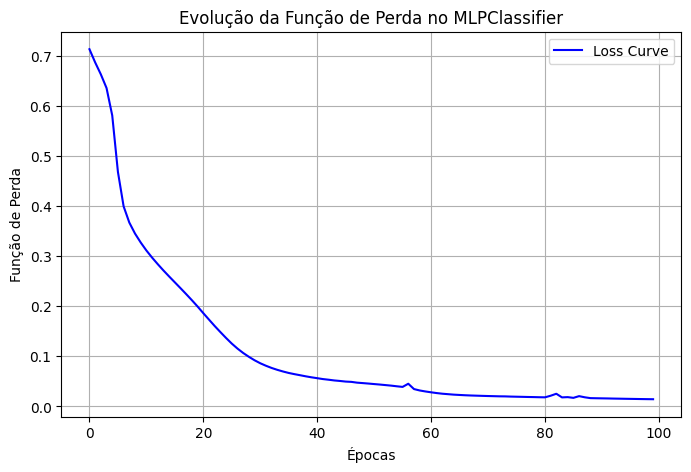

In [ ]:
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

mlp = MLPClassifier(hidden_layer_sizes=(
        512, 256, 128, 64, 32, 16, 16, 32, 64, 128,
        128, 64, 32, 16, 16, 32, 64, 128, 256, 512),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.000005,
                    alpha=0.000001,
                    max_iter=100,
                    random_state=42,
                    verbose=True,
                    early_stopping=False,
                    tol=0.0)

mlp.fit(X_train, y_train)

# funcao de perda
plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_, label="Loss Curve", color='b')
plt.xlabel("Épocas")
plt.ylabel("Função de Perda")
plt.title("Evolução da Função de Perda no MLPClassifier")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# tabela de metricas
y_pred = mlp.predict(X_test)

print("\n📊 Tabela de Métricas:\n")
print(classification_report(y_test, y_pred, digits=4))


📊 Tabela de Métricas:

              precision    recall  f1-score   support

           0     0.9959    0.9978    0.9968      4106
           1     0.9978    0.9959    0.9968      4130

    accuracy                         0.9968      8236
   macro avg     0.9968    0.9968    0.9968      8236
weighted avg     0.9968    0.9968    0.9968      8236



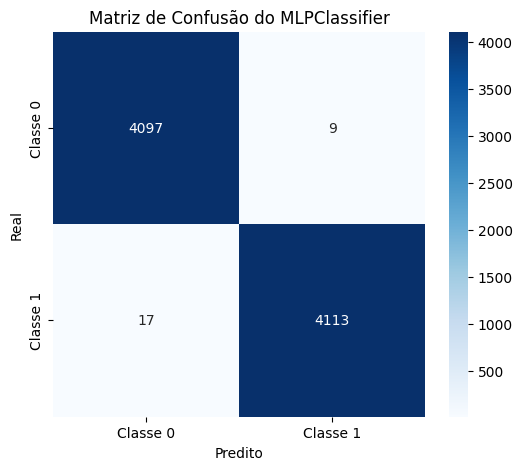

In [ ]:
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão do MLPClassifier")
plt.show()

In [ ]:
# salvamento do modelo
import pickle
with open('mlp_model.pkl', 'wb') as file:
   pickle.dump(mlp, file)